In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest, GradientBoostingRegressor, RandomForestRegressor
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, LinearRegression, LassoLarsIC
from sklearn.feature_selection import SelectKBest, f_regression, RFECV
from sklearn.svm import SVR
from statsmodels.stats.outliers_influence import variance_inflation_factor, OLSInfluence
from scipy.stats import kurtosis, skew, boxcox
from regressors import stats
from numpy import mean
from numpy import std
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train = pd.read_csv('./data/train_filled_na.csv')
test = pd.read_csv('./data/test_filled_na.csv')
train.drop('Id', axis = 1, inplace=True)
test.drop('Id', axis = 1, inplace=True)

# Outlier Detection

In [3]:
scaler = StandardScaler()
X_Scaled = scaler.fit_transform(train.loc[:, train.columns != 'SalePrice'])
X_Scaled = pd.DataFrame(X_Scaled, columns = train.columns[train.columns != 'SalePrice'])
y = train['SalePrice']

In [4]:
X_sm = sm.add_constant(X_Scaled)
model = sm.OLS(list(y),X_sm)
results = model.fit()

In [5]:
C, P = OLSInfluence(results).cooks_distance

/Users/baileyrusso/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:693: RuntimeWarning: invalid value encountered in sqrt
  return self.resid / sigma / np.sqrt(1 - hii)
/Users/baileyrusso/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:713: RuntimeWarning: divide by zero encountered in true_divide
  cooks_d2 *= hii / (1 - hii)


<AxesSubplot:title={'center':"Cook's Distance Outlier Detection"}, xlabel='instance', ylabel='distance'>

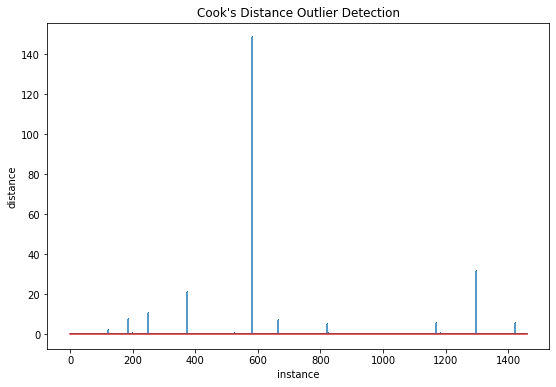

In [6]:
def plot_cooks_distance(c):
    _, ax = plt.subplots(figsize=(9,6))
    ax.stem(c, markerfmt=",")
    ax.set_xlabel("instance")
    ax.set_ylabel("distance")
    ax.set_title("Cook's Distance Outlier Detection")
    return ax


plot_cooks_distance(C)

In [7]:
#influential_points = C[C > 1]
#train.merge(pd.DataFrame(influential_points), left_index=True, right_index=True)
outliers = pd.DataFrame(C[C > 1])
outliers.columns = ["Cook's Distance"]
outliers

,Cook's Distance
120,2.218727
185,7.334633
250,10.342979
375,21.145168
583,148.526322
666,6.932813
821,4.842004
944,inf
1170,5.547019
1275,inf


In [8]:
#data_mean, data_std = mean(train), std(train)

In [9]:
# cut_off = data_std * 3
# lower, upper = data_mean - cut_off, data_mean + cut_off

# outliers = {}
# for col in ['LotFrontage','LotArea','MasVnrArea','YearBuilt','YearRemodAdd','BsmtFinSF1','BsmtFinSF2',
#             'BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','GrLivArea','GarageArea','WoodDeckSF',
#            'OpenPorchSF','EnclosedPorch']:
#     #train[train['LotArea'].between(lower['LotArea'], upper['LotArea'], inclusive=False)]
#     m = train[col].between(lower[col], upper[col], inclusive=True)
#     outliers[col] = train[~m]
    
    

In [10]:
# outlier_indices = set()
# for col in outliers:
#     print(col, len(outliers[col]))
#     for idx in list(outliers[col].index):
#         #print(idx)
#         outlier_indices.add(idx)
        

In [11]:
train = train.drop(outliers.index, axis=0)

# Log Transformations

In [12]:
def logTransform(data, colsToTransform):
    for col in colsToTransform:
        data[col] = np.log1p(data[col])
        

In [13]:
colsToTransform = ['SalePrice']
logTransform(train, colsToTransform)

# Modeling

In [14]:
def getFeatureImportance(num, cols, features_importances_, sort):
    
    feature_importances = zip(cols, features_importances_)
    sorted_importance = sorted(list(feature_importances),key= lambda x: abs(x[1]),reverse=False if sort == 'ascending' else True)

    f, ax = plt.subplots(figsize=(13, 9))
    sns.barplot([x[0] for x in sorted_importance[:num]], [x[1] for x in sorted_importance[:num]])
    plt.xticks(rotation=90)
    
    return sorted_importance

## Ridge Regression

In [15]:
scaler = StandardScaler()
X_Scaled = scaler.fit_transform(train.loc[:, train.columns != 'SalePrice'])
X_Scaled = pd.DataFrame(X_Scaled, columns = train.columns[train.columns != 'SalePrice'])
y = train['SalePrice']

In [16]:
model = Ridge()
params = {'alpha':[0.0001,0.001,0.01,0.1,1,10,50,75,100,200,300,400,500,1000,2000]}
gridRidge = GridSearchCV(model, param_grid=params, cv=5)
gridRidge.fit(X_Scaled, y)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 50, 75, 100,
                                   200, 300, 400, 500, 1000, 2000]})

In [17]:
gridRidge.cv_results_

{'mean_fit_time': array([0.09867682, 0.00703831, 0.00712123, 0.00704131, 0.00701241,
        0.00739784, 0.00725589, 0.00753994, 0.00760875, 0.0078187 ,
        0.00751505, 0.00775251, 0.00758243, 0.00797219, 0.0075222 ]),
 'std_fit_time': array([1.82286993e-01, 2.83786116e-04, 1.75678458e-04, 1.72363250e-04,
        1.54259982e-04, 3.56002273e-04, 2.67292327e-04, 2.20102547e-04,
        2.09431342e-04, 5.15671951e-04, 3.83475443e-04, 3.30378393e-04,
        5.05480923e-04, 4.57239482e-04, 1.87725563e-04]),
 'mean_score_time': array([0.00338416, 0.00359545, 0.00343199, 0.00344791, 0.00332832,
        0.00369177, 0.00347004, 0.0036921 , 0.0034874 , 0.0037231 ,
        0.0038085 , 0.00371327, 0.00396662, 0.00377922, 0.00375128]),
 'std_score_time': array([6.45166843e-05, 2.21594575e-04, 1.43406459e-04, 1.04679452e-04,
        9.50924963e-05, 2.00257335e-04, 1.36355635e-04, 8.83588904e-05,
        6.09664605e-05, 2.96428089e-04, 3.22978109e-04, 1.43870914e-04,
        2.82274082e-04, 2.14

In [18]:
gridRidge.best_params_

{'alpha': 400}

In [19]:
gridRidge.best_score_

0.8930472543086225

/Users/baileyrusso/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[('OverallCond', 0.030003110375766476),
 ('TotalIndoorSF', 0.02652958189580847),
 ('GrLivArea', 0.025958701800727905),
 ('TotalSF', 0.025781436324412082),
 ('OverallQual', 0.025719178667690554),
 ('GrLivAreaHighQualitySF', 0.02479249542530956),
 ('1stFlrSF', 0.02250401972027363),
 ('YearRemodAdd', 0.021689953092303173),
 ('BsmtFinSF1', 0.019741877629902857),
 ('TotalBsmtSF', 0.01971744770138295),
 ('YearBuilt', 0.018864168143495556),
 ('NeighborhoodDummy_NridgHt', 0.018297895720341344),
 ('BsmtQualDummy_Ex', 0.018089078380037652),
 ('CentralAirDummy_Y', 0.016941668506693017),
 ('SaleConditionDummy_Normal', 0.01637686760485346),
 ('NeighborhoodDummy_Crawfor', 0.016270207185985985),
 ('Condition2Dummy_PosN', -0.016138367330564344),
 ('NeighborhoodDummy_MeadowV', -0.016093677645048928),
 ('GarageCars', 0.01576476121467462),
 ('NeighborhoodDummy_StoneBr', 0.0151168869658498),
 ('GarageArea', 0.015010111854899299),
 ('KitchenQualDummy_TA', -0.014532762518475142),
 ('MSSubClassDummy_30', -0.

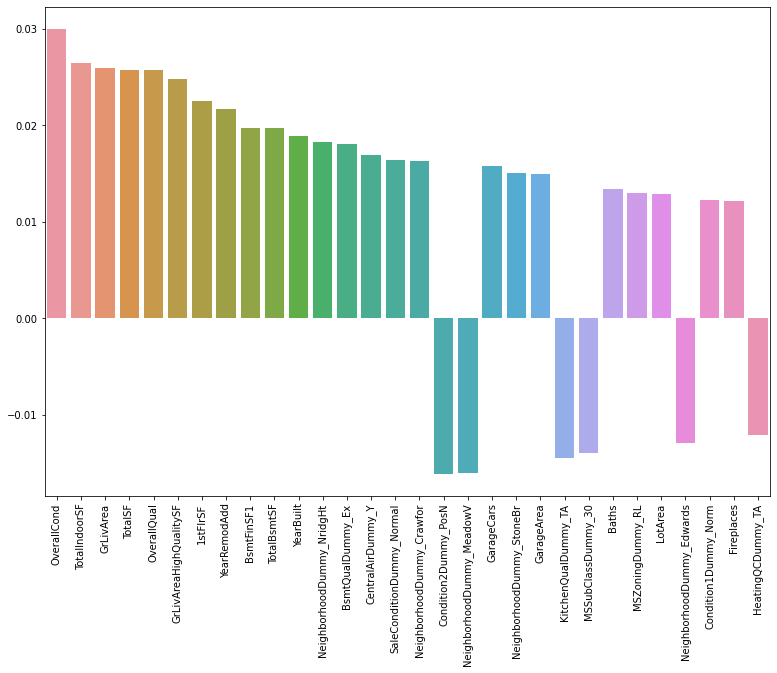

In [20]:
getFeatureImportance(30, X_Scaled.columns, gridRidge.best_estimator_.coef_,'descending')

In [21]:
gridRidge.score(X_Scaled, y)

0.9279959639786199

In [22]:
gridRidge.cv_results_

{'mean_fit_time': array([0.09867682, 0.00703831, 0.00712123, 0.00704131, 0.00701241,
        0.00739784, 0.00725589, 0.00753994, 0.00760875, 0.0078187 ,
        0.00751505, 0.00775251, 0.00758243, 0.00797219, 0.0075222 ]),
 'std_fit_time': array([1.82286993e-01, 2.83786116e-04, 1.75678458e-04, 1.72363250e-04,
        1.54259982e-04, 3.56002273e-04, 2.67292327e-04, 2.20102547e-04,
        2.09431342e-04, 5.15671951e-04, 3.83475443e-04, 3.30378393e-04,
        5.05480923e-04, 4.57239482e-04, 1.87725563e-04]),
 'mean_score_time': array([0.00338416, 0.00359545, 0.00343199, 0.00344791, 0.00332832,
        0.00369177, 0.00347004, 0.0036921 , 0.0034874 , 0.0037231 ,
        0.0038085 , 0.00371327, 0.00396662, 0.00377922, 0.00375128]),
 'std_score_time': array([6.45166843e-05, 2.21594575e-04, 1.43406459e-04, 1.04679452e-04,
        9.50924963e-05, 2.00257335e-04, 1.36355635e-04, 8.83588904e-05,
        6.09664605e-05, 2.96428089e-04, 3.22978109e-04, 1.43870914e-04,
        2.82274082e-04, 2.14

## Lasso Regression

In [23]:
model = Lasso()
params = {'alpha':[0.0075,0.005,0.001,0.01,0.1,1,10,50,75,100,1000,2000],'max_iter':[1000]}
gridLasso = GridSearchCV(model, param_grid=params, cv=5)
gridLasso.fit(X_Scaled, y)

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0075, 0.005, 0.001, 0.01, 0.1, 1, 10, 50,
                                   75, 100, 1000, 2000],
                         'max_iter': [1000]})

In [24]:
gridLasso.cv_results_

{'mean_fit_time': array([0.03006854, 0.04011469, 0.11632061, 0.02468476, 0.00909939,
        0.00690451, 0.0061656 , 0.00661287, 0.00665956, 0.00671597,
        0.00703931, 0.00685463]),
 'std_fit_time': array([0.00608956, 0.00850493, 0.01114328, 0.00527064, 0.00052398,
        0.00072966, 0.00018266, 0.00027351, 0.00019736, 0.00025826,
        0.0003293 , 0.00033425]),
 'mean_score_time': array([0.0035347 , 0.00384278, 0.00362277, 0.00361676, 0.00342269,
        0.00393763, 0.00353804, 0.00381107, 0.00373158, 0.00372071,
        0.00395761, 0.00390062]),
 'std_score_time': array([1.54045607e-04, 1.30871900e-04, 4.88466618e-04, 4.73486092e-05,
        5.86334063e-05, 2.31531551e-04, 1.99319107e-04, 1.68298755e-04,
        2.52131903e-05, 1.56261829e-04, 1.96698801e-04, 1.51665747e-04]),
 'param_alpha': masked_array(data=[0.0075, 0.005, 0.001, 0.01, 0.1, 1, 10, 50, 75, 100,
                    1000, 2000],
              mask=[False, False, False, False, False, False, False, False,
     

In [25]:
gridLasso.best_params_

{'alpha': 0.005, 'max_iter': 1000}

In [26]:
gridLasso.best_score_

0.8944708727756684

In [27]:
gridLasso.cv_results_

{'mean_fit_time': array([0.03006854, 0.04011469, 0.11632061, 0.02468476, 0.00909939,
        0.00690451, 0.0061656 , 0.00661287, 0.00665956, 0.00671597,
        0.00703931, 0.00685463]),
 'std_fit_time': array([0.00608956, 0.00850493, 0.01114328, 0.00527064, 0.00052398,
        0.00072966, 0.00018266, 0.00027351, 0.00019736, 0.00025826,
        0.0003293 , 0.00033425]),
 'mean_score_time': array([0.0035347 , 0.00384278, 0.00362277, 0.00361676, 0.00342269,
        0.00393763, 0.00353804, 0.00381107, 0.00373158, 0.00372071,
        0.00395761, 0.00390062]),
 'std_score_time': array([1.54045607e-04, 1.30871900e-04, 4.88466618e-04, 4.73486092e-05,
        5.86334063e-05, 2.31531551e-04, 1.99319107e-04, 1.68298755e-04,
        2.52131903e-05, 1.56261829e-04, 1.96698801e-04, 1.51665747e-04]),
 'param_alpha': masked_array(data=[0.0075, 0.005, 0.001, 0.01, 0.1, 1, 10, 50, 75, 100,
                    1000, 2000],
              mask=[False, False, False, False, False, False, False, False,
     

/Users/baileyrusso/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[('TotalSF', 0.11452043819744845),
 ('GrLivArea', 0.07459368995833543),
 ('YearBuilt', 0.05307543206056887),
 ('OverallCond', 0.04051850940484263),
 ('OverallQual', 0.036442999743745055),
 ('BsmtFinSF1', 0.029127715430322637),
 ('BsmtQualDummy_Ex', 0.022492551731828275),
 ('YearRemodAdd', 0.020919402172921518),
 ('Condition2Dummy_PosN', -0.019111284488801606),
 ('GarageCars', 0.018373527635769344),
 ('SaleTypeDummy_New', 0.018284259599400523),
 ('Fireplaces', 0.0182423785405204),
 ('NeighborhoodDummy_Crawfor', 0.01782028445776836),
 ('NeighborhoodDummy_NridgHt', 0.016861552459620663),
 ('FoundationDummy_PConc', 0.01620552616596478),
 ('MSZoningDummy_RL', 0.01483711277582018),
 ('CentralAirDummy_Y', 0.014533205358618333),
 ('KitchenAbvGr', -0.014167340304845405),
 ('LotArea', 0.013580216847787187),
 ('SaleConditionDummy_Normal', 0.013079753365706355),
 ('Condition1Dummy_Norm', 0.01288088961046268),
 ('NeighborhoodDummy_StoneBr', 0.012703526800651586),
 ('NeighborhoodDummy_MeadowV', -0.0

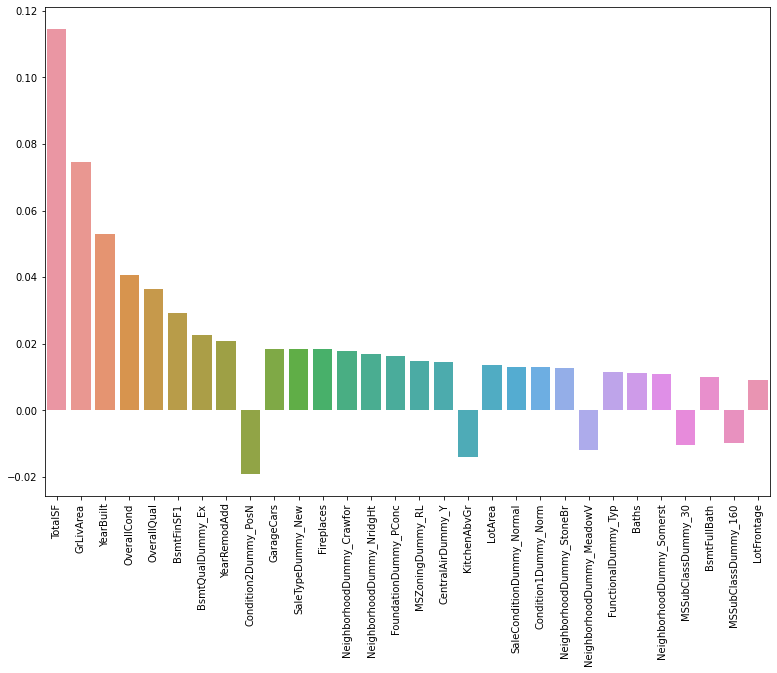

In [28]:
getFeatureImportance(30, X_Scaled.columns, gridLasso.best_estimator_.coef_, '')

In [29]:
gridLasso.score(X_Scaled, y)

0.9195328337890243

## Linear Regression on Lasso Selected Features

In [30]:
lasso_coef_estimates = list(zip(X_Scaled.columns,gridLasso.best_estimator_.coef_))
lasso_coef_non_zero = [var[0] for var in lasso_coef_estimates if var[1] != 0]

In [31]:
X_sm = X_Scaled[lasso_coef_non_zero]
X_sm = sm.add_constant(X_sm)
model = sm.OLS(list(y),X_sm)
results = model.fit()

In [32]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     222.0
Date:                Wed, 16 Mar 2022   Prob (F-statistic):               0.00
Time:                        09:20:05   Log-Likelihood:                 1164.0
No. Observations:                1448   AIC:                            -2172.
Df Residuals:                    1370   BIC:                            -1760.
Df Model:                          77                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        12.0246      0.003   4109.350      0.000      12.019      12.030
LotFrontage                   0.0130      0.004      3.181      0.002       0.005       0.021
LotArea                       0.0147      0.004      4.002      0.000       0.007       0.022
OverallQual                   0.0308      0.004      7.091      0.000       0.022       0.039
OverallCond                   0.0443      0.004     10.730      0.000       0.036       0.052
YearBuilt                     0.0585      0.009      6.831      0.000       0.042       0.075
YearRemodAdd                  0.0177      0.005      3.599      0.000       0.008       0.027
MasVnrArea                    0.0079      0.004      2.111      0.035       0.001       0.015
BsmtExposure                 -0.0081      0.003     -2.380      0.017      -0.015      -0.001
BsmtFinType1                 -0.0024      0.004     -0.583      0.560      -0.010       0.006
BsmtFinSF1                    0.0314      0.005      5.923      0.000       0.021       0.042
BsmtFinSF2                    0.0056      0.003      1.641      0.101      -0.001       0.012
GrLivArea                     0.0824      0.009      9.145      0.000       0.065       0.100
BsmtFullBath                  0.0131      0.004      3.049      0.002       0.005       0.022
HalfBath                      0.0026      0.004      0.665      0.506      -0.005       0.010
KitchenAbvGr                 -0.0156      0.004     -4.447      0.000      -0.023      -0.009
Fireplaces                    0.0151      0.008      2.010      0.045       0.000       0.030
GarageFinish                 -0.0026      0.004     -0.675      0.500      -0.010       0.005
GarageCars                    0.0201      0.005      3.720      0.000       0.009       0.031
WoodDeckSF                    0.0095      0.003      2.864      0.004       0.003       0.016
ScreenPorch                   0.0062      0.003      1.963      0.050    2.98e-06       0.012
MoSold                        0.0055      0.003      1.832      0.067      -0.000       0.011
hasFireplace                 -0.0002      0.008     -0.024      0.981      -0.016       0.015
TotalSF                       0.0960      0.009     10.461      0.000       0.078       0.114
Baths                         0.0148      0.006      2.470      0.014       0.003       0.027
MSSubClassDummy_30           -0.0125      0.004     -3.541      0.000      -0.019      -0.006
MSSubClassDummy_70            0.0088      0.004      2.434      0.015       0.002       0.016
MSSubClassDummy_160          -0.0146      0.004     -3.345      0.001      -0.023      -0.006
MSZoningDummy_FV              0.0104      0.007      1.582      0.114      -0.002       0.023
MSZoningDummy_RL              0.0179      0.005      3.277      0.001      

### Refit until all vars significant

In [33]:
while True:
    if len(results.pvalues[results.pvalues > 0.05]) == 0:
        break
    significant_coefs = results.pvalues[results.pvalues < 0.05]
    significant_coefs = significant_coefs[significant_coefs.index != 'const']

    X_sm = X_Scaled[significant_coefs.index]
    X_sm = sm.add_constant(X_sm)
    model = sm.OLS(list(y),X_sm)
    results = model.fit()

In [34]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     354.3
Date:                Wed, 16 Mar 2022   Prob (F-statistic):               0.00
Time:                        09:20:05   Log-Likelihood:                 1132.0
No. Observations:                1448   AIC:                            -2168.
Df Residuals:                    1400   BIC:                            -1915.
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        12.0246      0.003   4063.490      0.000      12.019      12.030
LotFrontage                   0.0144      0.004      3.587      0.000       0.007       0.022
LotArea                       0.0169      0.003      4.871      0.000       0.010       0.024
OverallQual                   0.0325      0.004      7.692      0.000       0.024       0.041
OverallCond                   0.0479      0.004     11.919      0.000       0.040       0.056
YearBuilt                     0.0698      0.007      9.920      0.000       0.056       0.084
YearRemodAdd                  0.0184      0.005      3.917      0.000       0.009       0.028
BsmtExposure                 -0.0091      0.003     -2.694      0.007      -0.016      -0.002
BsmtFinSF1                    0.0313      0.004      7.009      0.000       0.023       0.040
GrLivArea                     0.0882      0.008     10.458      0.000       0.072       0.105
BsmtFullBath                  0.0161      0.004      3.916      0.000       0.008       0.024
KitchenAbvGr                 -0.0162      0.003     -4.763      0.000      -0.023      -0.010
Fireplaces                    0.0200      0.004      5.358      0.000       0.013       0.027
GarageCars                    0.0207      0.005      4.507      0.000       0.012       0.030
WoodDeckSF                    0.0120      0.003      3.608      0.000       0.005       0.019
ScreenPorch                   0.0078      0.003      2.481      0.013       0.002       0.014
TotalSF                       0.0946      0.008     11.212      0.000       0.078       0.111
Baths                         0.0159      0.006      2.786      0.005       0.005       0.027
MSSubClassDummy_30           -0.0122      0.003     -3.502      0.000      -0.019      -0.005
MSSubClassDummy_70            0.0076      0.004      2.106      0.035       0.001       0.015
MSSubClassDummy_160          -0.0147      0.004     -4.000      0.000      -0.022      -0.008
MSZoningDummy_RL              0.0197      0.004      4.802      0.000       0.012       0.028
StreetDummy_Pave              0.0110      0.003      3.560      0.000       0.005       0.017
LotConfigDummy_CulDSac        0.0105      0.003      3.255      0.001       0.004       0.017
NeighborhoodDummy_BrkSide     0.0131      0.003      4.105      0.000       0.007       0.019
NeighborhoodDummy_Crawfor     0.0244      0.003      7.325      0.000       0.018       0.031
NeighborhoodDummy_Edwards    -0.0104      0.003     -3.267      0.001      -0.017      -0.004
NeighborhoodDummy_MeadowV    -0.0160      0.003     -4.958      0.000      -0.022      -0.010
NeighborhoodDummy_Mitchel    -0.0106      0.003     -3.427      0.001      -0.017      -0.005
NeighborhoodDummy_NoRidge     0.0087      0.003      2.586      0.010      

#### Get CV results of model

In [35]:
model = LinearRegression()
params = {}
gridLr = GridSearchCV(model, param_grid=params, cv=5)
gridLr.fit(X_Scaled[significant_coefs.index], y)

GridSearchCV(cv=5, estimator=LinearRegression(), param_grid={})

In [36]:
gridLr.cv_results_

{'mean_fit_time': array([0.00702605]),
 'std_fit_time': array([0.00556372]),
 'mean_score_time': array([0.00221214]),
 'std_score_time': array([0.00024541]),
 'params': [{}],
 'split0_test_score': array([0.91657676]),
 'split1_test_score': array([0.86790681]),
 'split2_test_score': array([0.86845708]),
 'split3_test_score': array([0.92578637]),
 'split4_test_score': array([0.91591313]),
 'mean_test_score': array([0.89892803]),
 'std_test_score': array([0.02534615]),
 'rank_test_score': array([1], dtype=int32)}

In [37]:
gridLr.score(X_Scaled[significant_coefs.index], y)

0.9224473062153176

## LassoLarsIC

In [38]:
model = LassoLarsIC()
params = {'criterion':['aic','bic']}
gridLL = GridSearchCV(model, param_grid=params, cv=5)
gridLL.fit(X_Scaled, y)

/Users/baileyrusso/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:615: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 148 iterations, i.e. alpha=5.086e-05, with an active set of 134 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
/Users/baileyrusso/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:615: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 156 iterations, i.e. alpha=4.589e-05, with an active set of 142 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
/Users/baileyrusso/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:615: ConvergenceWarning: Regressors in active set degenerate

/Users/baileyrusso/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:615: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 155 iterations, i.e. alpha=5.105e-05, with an active set of 139 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
/Users/baileyrusso/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:615: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 157 iterations, i.e. alpha=4.986e-05, with an active set of 141 regressors, and the smallest cholesky pivot element being 2.356e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
/Users/baileyrusso/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:615: ConvergenceWarning: Regressors in active set degenerate

/Users/baileyrusso/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:615: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 62 iterations, i.e. alpha=2.530e-04, with an active set of 58 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
/Users/baileyrusso/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:615: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 71 iterations, i.e. alpha=1.837e-04, with an active set of 65 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
/Users/baileyrusso/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:615: ConvergenceWarning: Regressors in active set degenerate. Dr

GridSearchCV(cv=5, estimator=LassoLarsIC(),
             param_grid={'criterion': ['aic', 'bic']})

In [39]:
ll_non_zero_coefs = list(zip(X_Scaled.columns,gridLL.best_estimator_.coef_))
ll_non_zero_coefs = [col[0] for col in ll_non_zero_coefs if col[1] != 0]

In [40]:
X_sm = X_Scaled[ll_non_zero_coefs]
X_sm = sm.add_constant(X_sm)
model = sm.OLS(list(y),X_sm)
results = model.fit()

In [41]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     434.4
Date:                Wed, 16 Mar 2022   Prob (F-statistic):               0.00
Time:                        09:20:06   Log-Likelihood:                 984.07
No. Observations:                1448   AIC:                            -1904.
Df Residuals:                    1416   BIC:                            -1735.
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        12.0246      0.003   3689.670      0.000      12.018      12.031
LotFrontage                   0.0125      0.004      3.090      0.002       0.005       0.020
LotArea                       0.0208      0.004      5.661      0.000       0.014       0.028
OverallQual                   0.0385      0.005      8.299      0.000       0.029       0.048
OverallCond                   0.0519      0.004     12.023      0.000       0.043       0.060
YearBuilt                     0.0608      0.007      8.410      0.000       0.047       0.075
YearRemodAdd                  0.0187      0.005      3.604      0.000       0.009       0.029
BsmtFinSF1                    0.0400      0.004     10.056      0.000       0.032       0.048
GrLivArea                     0.0742      0.009      8.365      0.000       0.057       0.092
KitchenAbvGr                 -0.0177      0.004     -4.852      0.000      -0.025      -0.011
Fireplaces                    0.0166      0.008      2.036      0.042       0.001       0.033
GarageCars                    0.0250      0.005      5.016      0.000       0.015       0.035
WoodDeckSF                    0.0093      0.004      2.617      0.009       0.002       0.016
hasFireplace                  0.0026      0.008      0.310      0.757      -0.014       0.019
TotalSF                       0.1183      0.009     13.293      0.000       0.101       0.136
Baths                         0.0125      0.006      2.046      0.041       0.001       0.025
MSSubClassDummy_30           -0.0143      0.004     -3.843      0.000      -0.022      -0.007
MSZoningDummy_RL              0.0037      0.006      0.623      0.533      -0.008       0.015
MSZoningDummy_RM             -0.0166      0.006     -2.777      0.006      -0.028      -0.005
NeighborhoodDummy_Crawfor     0.0208      0.004      5.876      0.000       0.014       0.028
NeighborhoodDummy_IDOTRR     -0.0110      0.004     -3.074      0.002      -0.018      -0.004
NeighborhoodDummy_NridgHt     0.0131      0.004      3.387      0.001       0.006       0.021
Condition1Dummy_Norm          0.0156      0.003      4.591      0.000       0.009       0.022
Condition2Dummy_PosN         -0.0263      0.003     -7.563      0.000      -0.033      -0.019
ExterQualDummy_TA            -0.0116      0.005     -2.138      0.033      -0.022      -0.001
FoundationDummy_PConc         0.0238      0.005      4.572      0.000       0.014       0.034
BsmtQualDummy_Ex              0.0286      0.004      7.005      0.000       0.021       0.037
HeatingQCDummy_TA            -0.0107      0.004     -2.818      0.005      -0.018      -0.003
CentralAirDummy_Y             0.0164      0.004      4.181      0.000       0.009       0.024
KitchenQualDummy_TA          -0.0053      0.005     -1.077      0.281      

### Refit until all vars significant

In [42]:
while True:
    if len(results.pvalues[results.pvalues > 0.05]) == 0:
        break
    significant_coefs = results.pvalues[results.pvalues < 0.05]
    significant_coefs = significant_coefs[significant_coefs.index != 'const']

    X_sm = X_Scaled[significant_coefs.index]
    X_sm = sm.add_constant(X_sm)
    model = sm.OLS(list(y),X_sm)
    results = model.fit()

In [43]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     481.4
Date:                Wed, 16 Mar 2022   Prob (F-statistic):               0.00
Time:                        09:20:06   Log-Likelihood:                 983.22
No. Observations:                1448   AIC:                            -1908.
Df Residuals:                    1419   BIC:                            -1755.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        12.0246      0.003   3691.419      0.000      12.018      12.031
LotFrontage                   0.0130      0.004      3.254      0.001       0.005       0.021
LotArea                       0.0206      0.004      5.680      0.000       0.013       0.028
OverallQual                   0.0388      0.005      8.378      0.000       0.030       0.048
OverallCond                   0.0524      0.004     12.217      0.000       0.044       0.061
YearBuilt                     0.0610      0.007      8.457      0.000       0.047       0.075
YearRemodAdd                  0.0197      0.005      3.869      0.000       0.010       0.030
BsmtFinSF1                    0.0400      0.004     10.091      0.000       0.032       0.048
GrLivArea                     0.0744      0.009      8.390      0.000       0.057       0.092
KitchenAbvGr                 -0.0181      0.004     -4.990      0.000      -0.025      -0.011
Fireplaces                    0.0190      0.004      4.311      0.000       0.010       0.028
GarageCars                    0.0251      0.005      5.047      0.000       0.015       0.035
WoodDeckSF                    0.0097      0.004      2.733      0.006       0.003       0.017
TotalSF                       0.1186      0.009     13.348      0.000       0.101       0.136
Baths                         0.0126      0.006      2.063      0.039       0.001       0.025
MSSubClassDummy_30           -0.0140      0.004     -3.777      0.000      -0.021      -0.007
MSZoningDummy_RM             -0.0196      0.004     -4.930      0.000      -0.027      -0.012
NeighborhoodDummy_Crawfor     0.0209      0.004      5.910      0.000       0.014       0.028
NeighborhoodDummy_IDOTRR     -0.0113      0.004     -3.186      0.001      -0.018      -0.004
NeighborhoodDummy_NridgHt     0.0134      0.004      3.476      0.001       0.006       0.021
Condition1Dummy_Norm          0.0156      0.003      4.587      0.000       0.009       0.022
Condition2Dummy_PosN         -0.0263      0.003     -7.571      0.000      -0.033      -0.019
ExterQualDummy_TA            -0.0132      0.005     -2.615      0.009      -0.023      -0.003
FoundationDummy_PConc         0.0244      0.005      4.734      0.000       0.014       0.034
BsmtQualDummy_Ex              0.0284      0.004      6.951      0.000       0.020       0.036
HeatingQCDummy_TA            -0.0111      0.004     -2.935      0.003      -0.019      -0.004
CentralAirDummy_Y             0.0161      0.004      4.132      0.000       0.008       0.024
FunctionalDummy_Typ           0.0171      0.003      4.947      0.000       0.010       0.024
FireplaceQuDummy_Gd           0.0116      0.004      2.849      0.004       0.004       0.020
===========================================================================

Text(0, 0.5, 'Residuals')

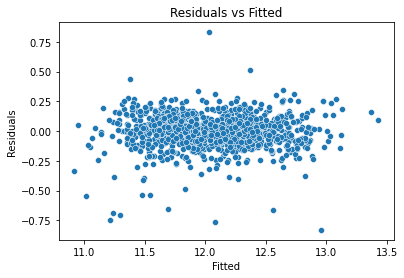

In [44]:
residuals = results.resid
fitted = results.fittedvalues
sns.scatterplot(x=fitted,y=residuals).set_title('Residuals vs Fitted')
plt.xlabel('Fitted')
plt.ylabel('Residuals')

#### Get CV results of model

In [45]:
model = LinearRegression()
params = {}
gridLr = GridSearchCV(model, param_grid=params, cv=5)
gridLr.fit(X_Scaled[significant_coefs.index], y)

GridSearchCV(cv=5, estimator=LinearRegression(), param_grid={})

In [46]:
gridLr.cv_results_

{'mean_fit_time': array([0.00332937]),
 'std_fit_time': array([0.00054429]),
 'mean_score_time': array([0.00210567]),
 'std_score_time': array([0.0003604]),
 'params': [{}],
 'split0_test_score': array([0.89792438]),
 'split1_test_score': array([0.84651473]),
 'split2_test_score': array([0.84492329]),
 'split3_test_score': array([0.9136679]),
 'split4_test_score': array([0.9128213]),
 'mean_test_score': array([0.88317032]),
 'std_test_score': array([0.03109158]),
 'rank_test_score': array([1], dtype=int32)}

/Users/baileyrusso/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[('TotalSF', 0.11862480996673867),
 ('GrLivArea', 0.07435909517262138),
 ('YearBuilt', 0.06098937427842538),
 ('OverallCond', 0.052442233101662294),
 ('BsmtFinSF1', 0.039971964892101496),
 ('OverallQual', 0.03882078788435345),
 ('BsmtQualDummy_Ex', 0.028351800000512024),
 ('Condition2Dummy_PosN', -0.02628675078829827),
 ('GarageCars', 0.025085011191650727),
 ('FoundationDummy_PConc', 0.02439165673621458),
 ('NeighborhoodDummy_Crawfor', 0.020870617000482056),
 ('LotArea', 0.02058661002441709),
 ('YearRemodAdd', 0.01966413936605247),
 ('MSZoningDummy_RM', -0.019596130346449223),
 ('Fireplaces', 0.019010536656889003),
 ('KitchenAbvGr', -0.018087956013840296),
 ('FunctionalDummy_Typ', 0.017054740269257854),
 ('CentralAirDummy_Y', 0.01605804291859625),
 ('Condition1Dummy_Norm', 0.01557899417768213),
 ('MSSubClassDummy_30', -0.013994365498939234),
 ('NeighborhoodDummy_NridgHt', 0.013362485257670677),
 ('ExterQualDummy_TA', -0.013219458608785744),
 ('LotFrontage', 0.013040947118785296),
 ('Ba

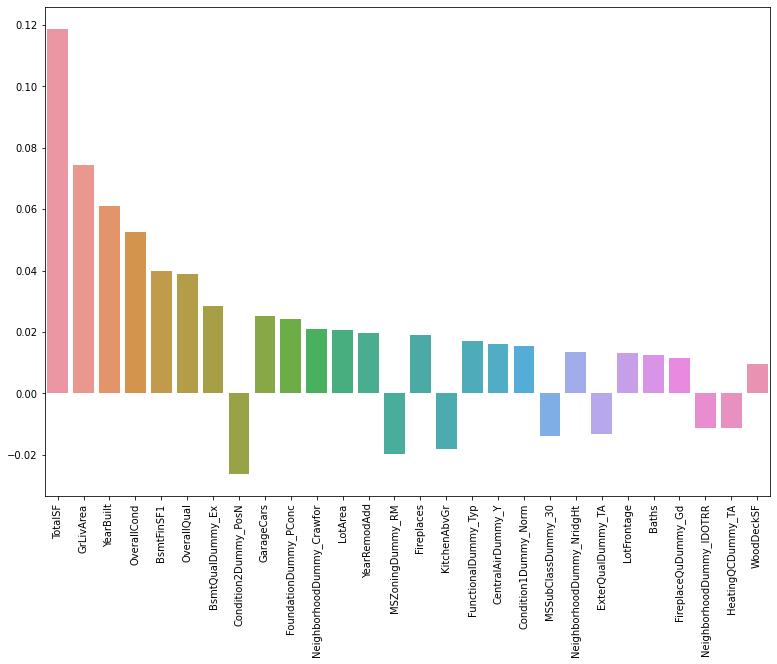

In [47]:
getFeatureImportance(50, X_Scaled[significant_coefs.index].columns, gridLr.best_estimator_.coef_,'descending')

In [48]:
estimates = pd.concat([pd.Series(X_Scaled[significant_coefs.index].columns), pd.Series(gridLr.best_estimator_.coef_)], axis=1)

In [49]:
estimates.columns = ['Variable', 'Coefficient Estimate']
estimates

,Variable,Coefficient Estimate
0,LotFrontage,0.013041
1,LotArea,0.020587
2,OverallQual,0.038821
3,OverallCond,0.052442
4,YearBuilt,0.060989
5,YearRemodAdd,0.019664
6,BsmtFinSF1,0.039972
7,GrLivArea,0.074359
8,KitchenAbvGr,-0.018088
9,Fireplaces,0.019011


In [50]:
gridLr.score(X_Scaled[significant_coefs.index], y)

0.9047504535571849

### Interpreting Coeficient Estimates

In [51]:
coef_estimates = list(zip(X_Scaled[significant_coefs.index].columns, gridLr.best_estimator_.coef_))
coef_estimates

[('LotFrontage', 0.013040947118785296),
 ('LotArea', 0.02058661002441709),
 ('OverallQual', 0.03882078788435345),
 ('OverallCond', 0.052442233101662294),
 ('YearBuilt', 0.06098937427842538),
 ('YearRemodAdd', 0.01966413936605247),
 ('BsmtFinSF1', 0.039971964892101496),
 ('GrLivArea', 0.07435909517262138),
 ('KitchenAbvGr', -0.018087956013840296),
 ('Fireplaces', 0.019010536656889003),
 ('GarageCars', 0.025085011191650727),
 ('WoodDeckSF', 0.00965212124429207),
 ('TotalSF', 0.11862480996673867),
 ('Baths', 0.012571182261617863),
 ('MSSubClassDummy_30', -0.013994365498939234),
 ('MSZoningDummy_RM', -0.019596130346449223),
 ('NeighborhoodDummy_Crawfor', 0.020870617000482056),
 ('NeighborhoodDummy_IDOTRR', -0.011275939501091648),
 ('NeighborhoodDummy_NridgHt', 0.013362485257670677),
 ('Condition1Dummy_Norm', 0.01557899417768213),
 ('Condition2Dummy_PosN', -0.02628675078829827),
 ('ExterQualDummy_TA', -0.013219458608785744),
 ('FoundationDummy_PConc', 0.02439165673621458),
 ('BsmtQualDummy_

In [52]:
var_unit_impact = []
for est in coef_estimates:
    if est[0] in colsToTransform:
        difference = np.exp(train['SalePrice'].mean() + est[1]) - np.exp(train['SalePrice'].mean())
        var_unit_impact.append((f'log({est[0]})',difference / train[est[0]].std()))
    else:
        difference = np.exp(train['SalePrice'].mean() + est[1]) - np.exp(train['SalePrice'].mean())
        var_unit_impact.append((est[0],difference / train[est[0]].std()))

In [53]:
pd.DataFrame(var_unit_impact, columns =['Coefficient', '1-unit change'])[:]

,Coefficient,1-unit change
0,LotFrontage,96.146118
1,LotArea,0.350224
2,OverallQual,4693.270691
3,OverallCond,8182.109142
4,YearBuilt,348.292255
5,YearRemodAdd,160.571908
6,BsmtFinSF1,15.604238
7,GrLivArea,25.217721
8,KitchenAbvGr,-13604.006201
9,Fireplaces,4994.310124


In [54]:
pd.DataFrame(var_unit_impact, columns =['Coefficient', '1-unit change'])[15:]

,Coefficient,1-unit change
15,MSZoningDummy_RM,-9100.030577
16,NeighborhoodDummy_Crawfor,19077.149070
17,NeighborhoodDummy_IDOTRR,-11848.509658
18,NeighborhoodDummy_NridgHt,9996.537605
19,Condition1Dummy_Norm,7652.760809
20,Condition2Dummy_PosN,-116483.327691
21,ExterQualDummy_TA,-4514.985145
22,FoundationDummy_PConc,8282.602144
23,BsmtQualDummy_Ex,17393.365928
24,HeatingQCDummy_TA,-4056.134557


# SVR

In [55]:
# model = SVR()
# params = {'kernel':['linear','rbf'], 'C':[0.01,1,10], 'epsilon':[0.01,0.1,1,10]}

# gridSvr = GridSearchCV(model, param_grid=params, cv=5)
# gridSvr.fit(X_Scaled, y)
# print(gridSvr.cv_results_)
# print(gridSvr.best_params_)
# print(gridSvr.best_score_)

In [56]:
# gridSvr.score(X_Scaled, y)

# SVR w/ Lasso Lars IC Selected Features

In [57]:
# model = SVR()
# params = {'kernel':['linear','rbf'], 'C':[0.01,1,10], 'epsilon':[0.01,0.1,1,10]}

# gridSvr = GridSearchCV(model, param_grid=params, cv=5)
# gridSvr.fit(X_Scaled[significant_coefs.index], y)
# print(gridSvr.cv_results_)
# print(gridSvr.best_params_)
# print(gridSvr.best_score_)

In [58]:
# gridSvr.score(X_Scaled[significant_coefs.index], y)

In [59]:
# getFeatureImportance(30, X_Scaled[significant_coefs.index].columns, gridSvr.best_estimator_.coef_[0], '')

In [60]:
# coef_estimates = list(zip(X_Scaled[significant_coefs.index].columns, gridSvr.best_estimator_.coef_[0]))
# coef_estimates

In [61]:
# var_unit_impact = []
# for est in coef_estimates:
#     difference = np.exp(train['SalePrice'].mean() + est[1]) - np.exp(train['SalePrice'].mean())
#     var_unit_impact.append((est[0],difference / train[est[0]].std()))

In [62]:
# var_unit_impact

# Test Predictions

In [63]:
X_test_scaled = scaler.transform(test)

In [64]:
X_test_scaled = pd.DataFrame(X_test_scaled, columns=test.columns)

In [65]:
gridLr_predictions = gridLr.predict(X_test_scaled[significant_coefs.index])
gridLr_predictions = pd.Series(np.exp(np.array(gridLr_predictions)))
gridLr_predictions.index = gridLr_predictions.index + 1461
gridLr_predictions = pd.DataFrame(gridLr_predictions, columns=['SalePrice'])
gridLr_predictions = gridLr_predictions.rename_axis('Id')

In [66]:
#gridLr_predictions.to_csv('./submissions/submission11.csv')